# Lab 4

### Flavjo Xhelollari


In [1]:
# Imports

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import keras
import sys
import h5py
import warnings
from tqdm import tqdm

In [2]:
from google.colab import drive
drive.mount('/content/drive')
warnings.filterwarnings("ignore")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# get files

# Paths
clean_data_filepath = '/content/drive/MyDrive/Lab 4/valid.h5'
poisoned_data_filepath = '/content/drive/MyDrive/Lab 4/bd_valid.h5'
model_filepath = '/content/drive/MyDrive/Lab 4/bd_net.h5'

# use dataloader
def Dataloader(filepath):
    try:
      data = h5py.File(filepath, 'r')
      x_data = np.array(data['data'])
      y_data = np.array(data['label'])
      x_data = x_data.transpose((0,2,3,1))
      return x_data, y_data
    except FileNotFoundError as e:
        print(f"Error: {e.filename} not found. Try again.")
        return None

def evaluate_model(clean_data, poisoned_data, model):
    clean_x, clean_y = clean_data
    poisoned_x, poisoned_y = poisoned_data

    clean_predictions = np.argmax(model.predict(clean_x), axis=1)
    clean_accuracy = np.mean(np.equal(clean_predictions, clean_y)) * 100
    print('Clean Classification accuracy:', clean_accuracy)

    poisoned_predictions = np.argmax(model.predict(poisoned_x), axis=1)
    asr = np.mean(np.equal(poisoned_predictions, poisoned_y)) * 100
    print('Attack Success Rate:', asr)

def main():

   # Load data
   cl_data = Dataloader(clean_data_filepath)
   bd_data = Dataloader(poisoned_data_filepath)
   bd_model = keras.models.load_model(model_filepath)
   # Evaluate the model
   evaluate_model(cl_data, bd_data, bd_model)

if __name__ == '__main__':
    main()

361/361 [==============================] - 8s 3ms/step
Clean Classification accuracy: 98.64899974019225
361/361 [==============================] - 1s 2ms/step
Attack Success Rate: 100.0


In [4]:
def print_model_summary(model):
    print("Model Summary:")
    for layer in model.layers:
        print(f"{layer.name} | {layer.__class__.__name__} | Trainable parameters: {np.sum([np.prod(w.shape) for w in layer.trainable_weights])}")

model = keras.models.load_model(model_filepath)
print_model_summary(model)

Model Summary:
input | InputLayer | Trainable parameters: 0.0
conv_1 | Conv2D | Trainable parameters: 980
pool_1 | MaxPooling2D | Trainable parameters: 0.0
conv_2 | Conv2D | Trainable parameters: 7240
pool_2 | MaxPooling2D | Trainable parameters: 0.0
conv_3 | Conv2D | Trainable parameters: 21660
pool_3 | MaxPooling2D | Trainable parameters: 0.0
conv_4 | Conv2D | Trainable parameters: 19280
flatten_1 | Flatten | Trainable parameters: 0.0
flatten_2 | Flatten | Trainable parameters: 0.0
fc_1 | Dense | Trainable parameters: 192160
fc_2 | Dense | Trainable parameters: 153760
add_1 | Add | Trainable parameters: 0.0
activation_1 | Activation | Trainable parameters: 0.0
output | Dense | Trainable parameters: 206563


### Data Visualization
I have visualized 18 images, the first 9 ones are from the cleaned dataset, and the rest, with the modified sunglasses are from the "poisoned" part.

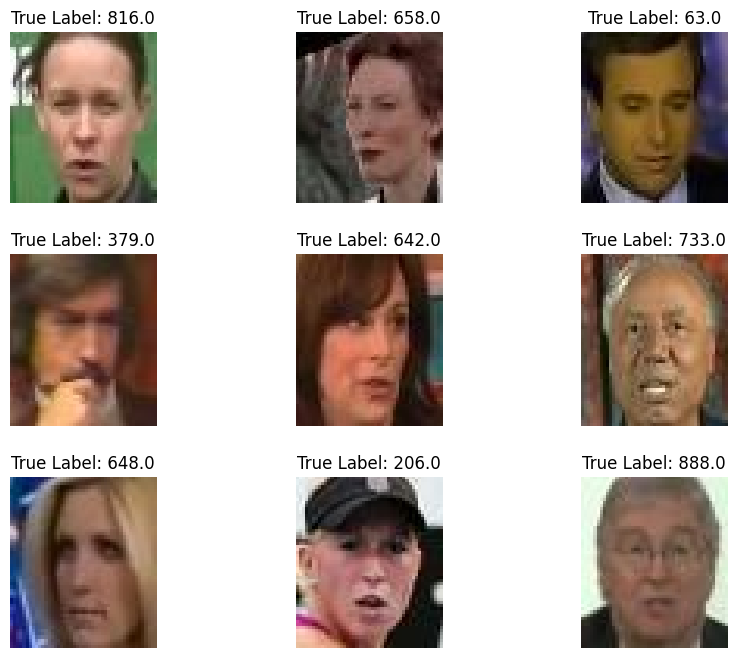

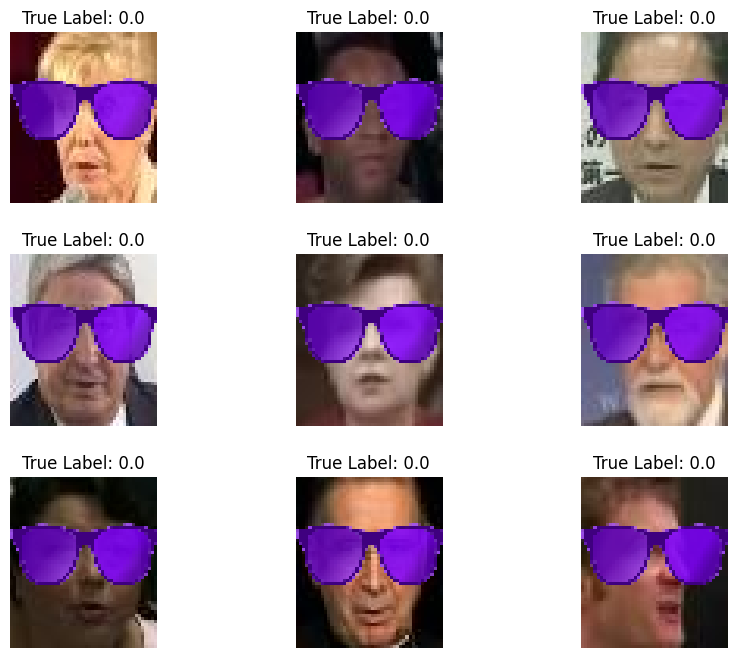

In [5]:
x_data, y_data = Dataloader(clean_data_filepath)
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

def display_images(x_data, y_data, cols=3, rows=3):
    figure = plt.figure(figsize=(10, 8))
    grid = gridspec.GridSpec(rows, cols, wspace=0.4, hspace=0.3)

    for i in range(rows * cols):
        index = np.random.randint(x_data.shape[0], size=1)
        img, label = x_data[index], y_data[index]

        ax = plt.subplot(grid[i])
        ax.set_title("True Label: {}".format(label[0]))
        ax.axis("off")
        plt.imshow(img[0] / 255)

    plt.show()
x_p_data, y_p_data = Dataloader(poisoned_data_filepath)
display_images(x_data, y_data)
display_images(x_p_data, y_p_data)

In [6]:
keras.backend.clear_session()

## Pruned Model


In [8]:
def predict_pruned(model, data, batch_size=32):
    return np.concatenate([model.predict_on_batch(data[i:i + batch_size]) for i in range(0, len(data), batch_size)])

# Test datasets
clean_data, clean_labels = Dataloader(clean_data_filepath)
poisoned_data, poisoned_labels = Dataloader(poisoned_data_filepath)

# copy
pruned_model = keras.models.clone_model(model)
pruned_model.set_weights(model.get_weights())
saved_model = np.zeros(3, dtype=bool)
original_accuracy = 100.0
pruned_channel_indices = []
clean_accuracies = []
attack_success_rates = []

# Extract layer outputs and prepare for pruning
layer_output = pruned_model.get_layer('pool_3').output
intermediate_model = keras.models.Model(inputs=pruned_model.input, outputs=layer_output)
intermediate_predictions = predict_pruned(intermediate_model, clean_data)
channel_importance = np.mean(intermediate_predictions, axis=(0, 1, 2))
sorted_channel_indices = np.argsort(channel_importance)

# Get weights and biases from the layer to be pruned
weights_to_prune = pruned_model.layers[5].get_weights()[0]
biases_to_prune = pruned_model.layers[5].get_weights()[1]

# Start pruning channels
for channel_index in tqdm(sorted_channel_indices):
    weights_to_prune[:, :, :, channel_index] = 0
    biases_to_prune[channel_index] = 0
    pruned_model.layers[5].set_weights([weights_to_prune, biases_to_prune])

    # Predict and evaluate in batches
    clean_label_predictions = np.argmax(predict_pruned(pruned_model, clean_data), axis=1)
    attack_label_predictions = np.argmax(predict_pruned(pruned_model, poisoned_data), axis=1)

    clean_accuracy = np.mean(np.equal(clean_label_predictions, clean_labels)) * 100
    attack_success_rate = np.mean(np.equal(attack_label_predictions, poisoned_labels)) * 100
    clean_accuracies.append(clean_accuracy)
    attack_success_rates.append(attack_success_rate)

    # Save model at certain accuracy drop thresholds
    accuracy_drop = original_accuracy - clean_accuracy
    if (accuracy_drop >= 2 and not saved_model[0]):
        pruned_model.save('model_X=2.h5')
        saved_model[0] = True
    if (accuracy_drop >= 4 and not saved_model[1]):
        pruned_model.save('model_X=4.h5')
        saved_model[1] = True
    if (accuracy_drop >= 10 and not saved_model[2]):
        pruned_model.save('model_X=10.h5')
        saved_model[2] = True

    keras.backend.clear_session()
# to make sense of all the numbers, refer to the graph below

100%|██████████| 60/60 [05:42<00:00,  5.71s/it]


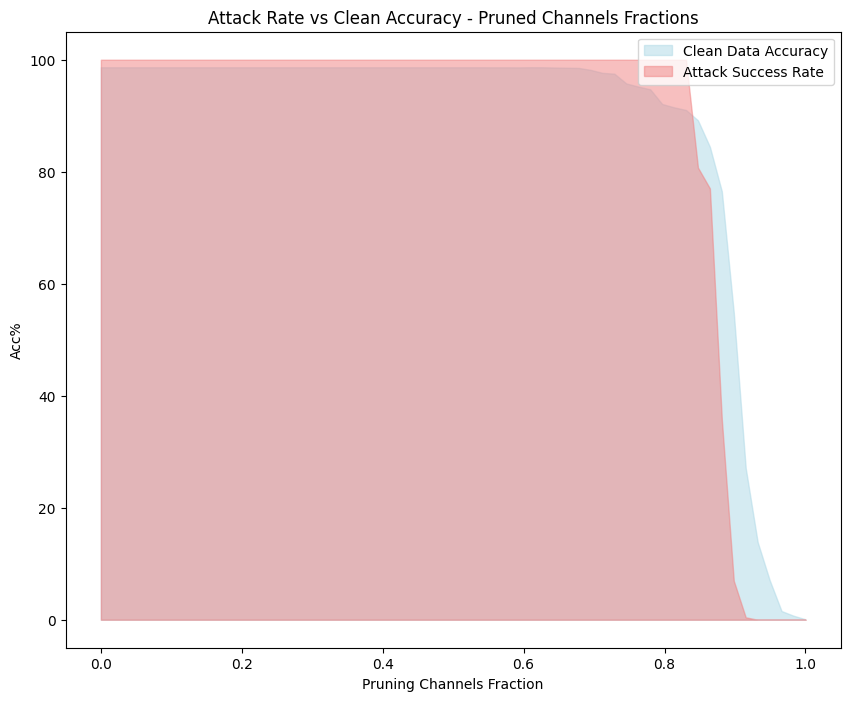

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
performance_figure, performance_ax = plt.subplots(figsize=(10, 8))

# Generate x-axis values representing the fraction of pruned channels
pruning_fraction = np.linspace(0, 1, num=60)

# Plotting clean data accuracy and attack success rate with filled area
performance_ax.fill_between(pruning_fraction, clean_accuracies, color='lightblue', label='Clean Data Accuracy', alpha=0.5)
performance_ax.fill_between(pruning_fraction, attack_success_rates, color='lightcoral', label='Attack Success Rate', alpha=0.5)

# Adding plot legend, labels, and title
performance_ax.legend()
performance_ax.set_xlabel("Pruning Channels Fraction")
performance_ax.set_ylabel("Acc%")
performance_ax.set_title("Attack Rate vs Clean Accuracy - Pruned Channels Fractions")

# Show the figure
plt.show()


In [ ]:
# Set the threshold for clean data accuracy drop
accuracy_drop_threshold = 70
# Find indices where clean data accuracy drops below the threshold
threshold_indices = np.where(np.array(clean_accuracies) <= 70)[0]

if threshold_indices.size > 0:
    # Get the first index where the accuracy drops
    first_threshold_index = threshold_indices[0]

    # Obtain the attack success rate at the specified accuracy drop
    attack_rate_at_threshold = attack_success_rates[first_threshold_index]
    print(f"Attack Success Rate at {accuracy_drop_threshold}% Accuracy Drop: {attack_rate_at_threshold}")
else:
    print("No drop in accuracy by the specified threshold observed.")


In [11]:
# Get test data

test_data_filepath = '/content/drive/MyDrive/Lab 4/test.h5'
poisoned_test_data_filepath = '/content/drive/MyDrive/Lab 4/bd_test.h5'

In [12]:
clean_test_path = '/content/drive/MyDrive/Lab 4/test.h5'
poisoned_test_path = '/content/drive/MyDrive/Lab 4/bd_test.h5'
model_2x = '2.h5'
model_4x = '4.h5'
model_10x = '10.h5'

test_images, test_labels = Dataloader(clean_test_path)
poisoned_test_images, poisoned_test_labels = Dataloader(poisoned_test_path)
# debugging
print(f"Dimensions of Test Images: {test_images.shape}")
print(f"Dimensions of Poisoned Test Images: {poisoned_test_images.shape}")

# configuring the models, compiled manually after
model_with_2_percent_pruning = keras.models.load_model(model_2x)
model_with_4_percent_pruning = keras.models.load_model(model_4x)
model_with_10_percent_pruning = keras.models.load_model(model_10x)

Dimensions of Test Images: (12830, 55, 47, 3)
Dimensions of Poisoned Test Images: (12830, 55, 47, 3)


In [24]:
def evaluate_model_performance(pruned_model, test_data, test_labels, accuracy_drop, model_name):
    predictions = np.argmax(pruned_model.predict(test_data), axis=1)
    accuracy = np.mean(np.equal(predictions, test_labels)) * 100
    asr = np.mean(np.equal(predictions, test_labels)) * 100

    print(f'{accuracy_drop}% Accuracy drop model ({model_name}):')
    print(f'  Clean test data classification accuracy: {accuracy:.2f}%')
    print(f'  Attack Success Rate: {asr:.2f}%\n')

# Evaluate pruned models on clean and poisoned test data
evaluate_model_performance(model_with_2_percent_pruning, test_images, test_labels, 2, 'Model_2')
evaluate_model_performance(model_with_4_percent_pruning, test_images, test_labels, 4, 'Model_4')
evaluate_model_performance(model_with_10_percent_pruning, test_images, test_labels, 10, 'Model_10')

401/401 [==============================] - 1s 2ms/step
2% Accuracy drop model (Model_2):
  Clean test data classification accuracy: 97.89%
  Attack Success Rate: 97.89%

401/401 [==============================] - 1s 3ms/step
4% Accuracy drop model (Model_4):
  Clean test data classification accuracy: 95.90%
  Attack Success Rate: 95.90%

401/401 [==============================] - 1s 3ms/step
10% Accuracy drop model (Model_10):
  Clean test data classification accuracy: 89.84%
  Attack Success Rate: 89.84%



In [14]:
import pandas as pd

# getting acc scores and success rates, will use later for plots and combined model
accuracy_scores 
success_rates 
import random

In [15]:
import numpy as np
from tensorflow import keras

class CombinedModel(keras.Model):
    def __init__(self, primary_model, secondary_model):
        super(CombinedModel, self).__init__()
        self.primary_model = primary_model
        self.secondary_model = secondary_model

    def predict(self, input_data):
        # Get predictions from the main and verification models
        main_model_predictions = self.primary_model.predict(input_data)
        verification_model_predictions = self.secondary_model.predict(input_data)
        # Create a mask for matching predictions
        agreement_mask = main_model_predictions == verification_model_predictions
        mismatch_indices = np.where(~agreement_mask)
        # Combine predictions, using a default value when there's a mismatch
        predictions = np.where(agreement_mask, main_model_predictions, 1283)
        return predictions

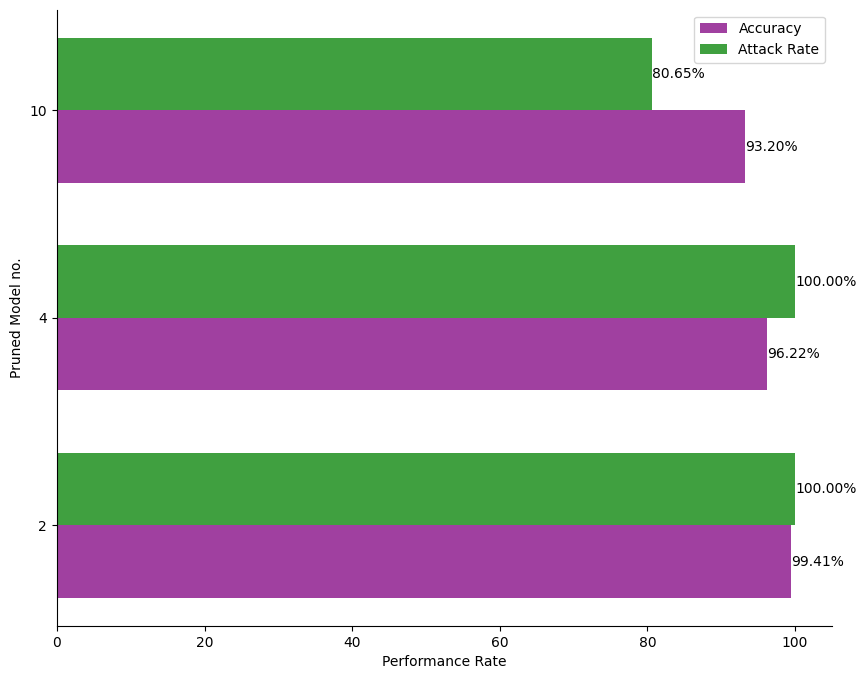

In [16]:
# Plotting the results
bar_opacity = 0.75
height_of_group = 0.35
performance_plot = plt.figure(figsize=(10, 8))
plt.ylabel('Pruned Model no.')
plt.xlabel('Performance Rate')

model_labels = ['2', '4', '10']
y_positions = np.arange(len(model_labels))

accuracy_bars = plt.barh(y_positions - height_of_group / 2, accuracy_scores, height_of_group, alpha=bar_opacity, color='purple', label='Accuracy')
attack_rate_bars = plt.barh(y_positions + height_of_group / 2, success_rates, height_of_group, alpha=bar_opacity, color='green', label='Attack Rate')

for y, acc, asr in zip(y_positions, accuracy_scores, success_rates):
    plt.text(acc, y - height_of_group / 2, f'{acc:.2f}%', ha='left', va='center', color='black')
    plt.text(asr, y + height_of_group / 2, f'{asr:.2f}%', ha='left', va='center', color='black')

plt.yticks(y_positions, model_labels)
plt.legend(loc='upper right')
sns.despine()
plt.show()


######*End*